In [12]:
import torch
torch.autograd.set_detect_anomaly(True)

In [13]:
import os
print("Available cores:", os.cpu_count())

# Check and display the GPU environment details using TensorFlow
if torch.cuda.is_available():
    print("Available GPUs:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])
    print("Num GPUs Available: ", torch.cuda.device_count())
else:
    print("No GPUs available.")

Available cores: 16
Available GPUs: ['NVIDIA GeForce RTX 2060 with Max-Q Design']
Num GPUs Available:  1


In [14]:
# Load dataset
from torchvision import datasets, transforms
# from torch.utils.data import DataLoader, TensorDataset

# Settings
# dataset = "MNIST"
# dataset = "FashionMNIST"
dataset = "CIFAR10"

if dataset == "MNIST":
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
    train_dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='../data', train=False, transform=transform, download=True)

elif dataset == "FashionMNIST":
    # Load Fashion-MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)), 
    ])
    train_dataset = datasets.FashionMNIST(root='../data', train=True, transform=transform, download=True)
    test_dataset = datasets.FashionMNIST(root='../data', train=False, transform=transform, download=True)

elif dataset == "CIFAR10":
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])    
    train_dataset = datasets.CIFAR10(root='../data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='../data', train=False, transform=transform, download=True)
    
else:
    raise ValueError(f"Unsupported dataset: {dataset}")

_smp_data, _ = train_dataset[0]
num_channels, height, width = _smp_data.shape
num_classes = len(train_dataset.classes)

print("Dataset:", dataset)
print("Number of Channels:", num_channels)
print("Width:", width)
print("Height:", height)
print("Number of Classes:", num_classes)

Files already downloaded and verified
Files already downloaded and verified
Dataset: CIFAR10
Number of Channels: 3
Width: 32
Height: 32
Number of Classes: 10


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class DefaultLinearGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)
        return F.linear(input, weight, bias)

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight) 
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)

        return grad_input, grad_weight, grad_bias

class DefaultLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(DefaultLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.weight, -bound, bound)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return DefaultLinearGrad.apply(input, self.weight, self.bias)


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class DefaultConv2dGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias, stride=1, padding=0):
        ctx.save_for_backward(x, weight, bias)
        ctx.stride = stride
        ctx.padding = padding
        return F.conv2d(x, weight, bias, stride, padding)

    @staticmethod
    def backward(ctx, grad_output):
        x, weight, bias = ctx.saved_tensors
        stride = ctx.stride
        padding = ctx.padding
        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            grad_input = F.grad.conv2d_input(x.shape, weight, grad_output, stride=stride, padding=padding)
        if ctx.needs_input_grad[1]:
            grad_weight = F.grad.conv2d_weight(x, weight.shape, grad_output, stride=stride, padding=padding)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(dim=[0, 2, 3])
        return grad_input, grad_weight, grad_bias, None, None

class DefaultConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(DefaultConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, *self.kernel_size))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x):
        return DefaultConv2dGrad.apply(x, self.weight, self.bias, self.stride, self.padding)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class USFLinearGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)
        return F.linear(input, weight, bias)

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            # grad_input = grad_output.mm(weight)
            grad_input = grad_output.mm( weight.sign() ) / math.sqrt(weight.size(1)) 
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)

        return grad_input, grad_weight, grad_bias

class USFLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(USFLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.weight, -bound, bound)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return USFLinearGrad.apply(input, self.weight, self.bias)

In [18]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class USFConv2dGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias, stride=1, padding=0):
        ctx.save_for_backward(x, weight, bias)
        ctx.stride = stride
        ctx.padding = padding
        return F.conv2d(x, weight, bias, stride, padding)

    @staticmethod
    def backward(ctx, grad_output):
        x, weight, bias = ctx.saved_tensors
        stride = ctx.stride
        padding = ctx.padding
        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            # grad_input = F.grad.conv2d_input(x.shape, weight, grad_output, stride=stride, padding=padding)
            grad_input = F.grad.conv2d_input(x.shape, weight.sign(), grad_output, stride=stride, padding=padding) / math.sqrt(weight.size(1))
        if ctx.needs_input_grad[1]:
            grad_weight = F.grad.conv2d_weight(x, weight.shape, grad_output, stride=stride, padding=padding)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(dim=[0, 2, 3])
        return grad_input, grad_weight, grad_bias, None, None

class USFConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(USFConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, *self.kernel_size))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x):
        return USFConv2dGrad.apply(x, self.weight, self.bias, self.stride, self.padding)

In [19]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import math

# class SBPGradFunction(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, input, weight, bias=None):
#         ctx.save_for_backward(input, weight, bias)
#         return F.linear(input, weight, bias)

#     @staticmethod
#     def backward(ctx, grad_output):
#         input, weight, bias = ctx.saved_tensors
#         grad_input = grad_weight = grad_bias = None

#         if ctx.needs_input_grad[0]:
#             grad_input = grad_output.mm(weight) 
#         if ctx.needs_input_grad[1]:
#             grad_weight = grad_output.t().mm(input)
#         if bias is not None and ctx.needs_input_grad[2]:
#             grad_bias = grad_output.sum(0)

#         return grad_input, grad_weight, grad_bias
    
# class SBPLinear(DefaultLinear):
#     def __init__(self, in_features, out_features, bias=True):
#         super(SBPLinear, self).__init__(in_features, out_features, bias)

#     # def reset_parameters(self):
#     #     fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
#     #     stdv = 1.0/ math.sqrt(fan_in)
#     #     nn.init.uniform_(self.weight, -stdv, stdv)
#     #     if self.bias is not None:
#     #         nn.init.uniform_(self.bias, -stdv, stdv)

#     def reset_parameters(self):
#         fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
#         stdv = 1.0 / math.sqrt(fan_in)
#         mid_point = self.weight.size(1) // 2
#         nn.init.uniform_(self.weight[:, mid_point:], -stdv, 0)
#         nn.init.uniform_(self.weight[:, :mid_point], 0, stdv)
#         if self.bias is not None:
#             nn.init.uniform_(self.bias, -stdv, stdv)

#     # def reset_parameters(self):
#     #     fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
#     #     stdv = 1.0 / math.sqrt(fan_in)
#     #     mid_point = self.weight.size(0) // 2
#     #     nn.init.uniform_(self.weight[mid_point:, :], -stdv, 0)
#     #     nn.init.uniform_(self.weight[:mid_point, :], 0, stdv)
#     #     if self.bias is not None:
#     #         nn.init.uniform_(self.bias, -stdv, stdv)

#     def forward(self, input):
#         return SBPGradFunction.apply(input, self.weight, self.bias)


In [20]:
class AdvancedConvNet(nn.Module):
    def __init__(self, in_channels, height, width, num_classes, conv_module=nn.Conv2d, linear_module=nn.Linear):
        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.num_classes = num_classes
        self.conv_module = conv_module
        self.linear_module = linear_module

        super(AdvancedConvNet, self).__init__()
        self.conv1 = conv_module(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = conv_module(64, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = conv_module(128, 256, kernel_size=3, padding=1)
        self.conv4 = conv_module(256, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        fc_input_features = 256 * (height // 4) * (width // 4)
        self.dropout = nn.Dropout(0.0)
        self.fc1 = linear_module(fc_input_features, 1024)
        self.fc2 = linear_module(1024, 512)
        self.fc3 = linear_module(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * (height // 4) * (width // 4))
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        x = self.fc3(x)
        return x

In [21]:
import torch.optim as optim
import random
import numpy as np
import torch

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    total_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return total_loss, accuracy

def train_and_evaluate(model, train_loader, test_loader, num_epochs, device=None):
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    losses = []
    accuracies = []

    initial_loss, initial_accuracy = evaluate_model(model, test_loader, device)
    losses.append(initial_loss)
    accuracies.append(initial_accuracy)
    print(f'Initial: Test set: Average loss: {initial_loss:.4f}, Accuracy: {initial_accuracy:.2f}%')

    for epoch in range(num_epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

        loss, accuracy = evaluate_model(model, test_loader, device)
        losses.append(loss)
        accuracies.append(accuracy)
        print(f'Epoch {epoch + 1}: Test set: Average loss: {loss:.4f}, Accuracy: {accuracy:.2f}%')

    return losses, accuracies


Experiment settings:
Dataset: CIFAR10 [3, 32, 32] -> 10
Number of epochs: 10
Batch size: 64
Seed: 0
Device: cuda
Network configuration:


AdvancedConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)
Training with DefaultLinear
Initial: Test set: Average loss: 2.3026, Accuracy: 10.00%
Epoch 1: Test set: Average loss: 1.5901, Accuracy: 41.53%
Epoch 2: Test set: Average loss: 1.3074, Accuracy: 52.69%
Epoch 3: Test set: Average loss: 1.1311, Accuracy: 59.55%
Epoch

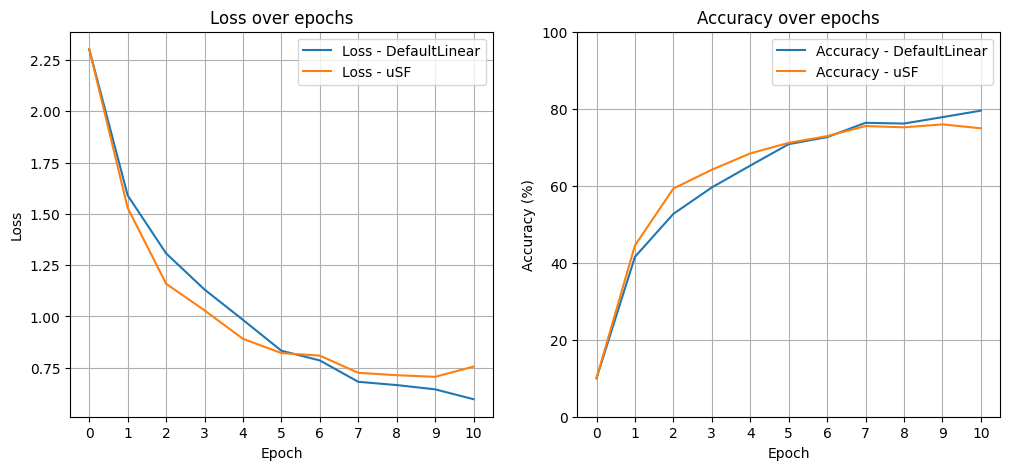

In [22]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

num_epochs = 10
batch_size = 64
seed = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

methods = [
    ('DefaultLinear', DefaultLinear, DefaultConv2d),
    ('uSF', USFLinear, USFConv2d),
    # ('Ours', SBPLinear)
]
plt.figure(figsize=(12, 5))

losses_dict = {}
accuracies_dict = {}
times_dict = {}
print("Experiment settings:")
print(f"Dataset: {dataset} [{num_channels}, {height}, {width}] -> {num_classes}")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Seed: {seed}")
print(f"Device: {device}")
print("Network configuration:")
model = AdvancedConvNet(num_channels, height, width, num_classes)
print(model) # Display the network architecture

for name, linear_layer, conv_layer in methods:
    print(f"Training with {name}")
    set_seed(seed) 
    model = AdvancedConvNet(num_channels, height, width, num_classes, linear_module=linear_layer, conv_module=conv_layer)
    losses, accuracies = train_and_evaluate(model, train_loader, test_loader, num_epochs, device)
    losses_dict[name] = losses
    accuracies_dict[name] = accuracies

plt.subplot(1, 2, 1)
for name, losses in losses_dict.items():
    plt.plot(range(-1, num_epochs), losses, label=f'Loss - {name}')  # Adjusted x-axis for initial loss
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(-1, num_epochs), labels=range(0, num_epochs+1))
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
for name, accuracies in accuracies_dict.items():
    plt.plot(range(-1, num_epochs), accuracies, label=f'Accuracy - {name}')  # Adjusted x-axis for initial accuracy
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(range(-1, num_epochs), labels=range(0, num_epochs+1))
plt.grid(True)
plt.legend()

plt.show()
